## Neural Networks (2022-2023)
### Lab session 1: Logistic regression in PyTorch

In [2]:
import torch

#### Part 1: Tensor computations

In [2]:
# The PyTorch is syntax is very similar to NumPy, the main exception
# being requires_grad=True, meaning that all operations on X will be
# tracked in order to compute gradients.
X = torch.randn((3, 2), requires_grad=True) # Tensor([Rows, Columns])

In [3]:
# A tensor is described by its type and shape.
print(X.dtype) # --> Type of the Tensor
print(X.shape) # --> Shape of the Tensor([Rows, Columns])

torch.float32
torch.Size([3, 2])


In [4]:
# In addition, any tensor lives on a certain device, and operations
# are only possible for tensors staying on the same device (not an 
# issue for now).
X.device

device(type='cpu')

In [6]:
# We do have a GPU!
torch.cuda.device_count()

1

In [7]:
# In case of a GPU, this is needed to send the tensor on the GPU.
# Otherwise, this can be specified in the constructor itself.
X.to('cuda')

tensor([[-1.1290, -1.1309],
        [ 0.0626, -1.7285],
        [-0.0756,  0.5983]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [20]:
# Indexing is also almost identical to NumPy.
X[0:2] # --> Extracts the first two rows. [0 to N-1]

# We can also index by rows and columns
X[0:2, :1] # --> Extracts the first two rows and first column. [0 to N-1, 1]

tensor([[-1.1290],
        [ 0.0626]], grad_fn=<SliceBackward0>)

In [21]:
# Simple matrix multiplication
X @ X.T

tensor([[ 2.5536,  1.8841, -0.5913],
        [ 1.8841,  2.9915, -1.0388],
        [-0.5913, -1.0388,  0.3636]], grad_fn=<MmBackward0>)

In [23]:
# Reshaping converts the tensor to a new tensor having a different shape.
# In some cases, it is possible to use a more efficient view operation, provided
# the view is compatible with the underlying data storage: 
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view
y = X.reshape((1, 6)) # --> Reshaping from a 3x2 Tensor to a 1x6 Tensor
print(y)

tensor([[-1.1290, -1.1309,  0.0626, -1.7285, -0.0756,  0.5983]],
       grad_fn=<ReshapeAliasBackward0>)


In [25]:
# Broadcasting can also be used in PyTorch:
# https://pytorch.org/docs/stable/notes/broadcasting.html

# The vector (y) is added to every corresponding row of the matrix Z (3, 6).
# Columns are the same, but as for the rows, we add the y-vector to every
# column of Z
Z = torch.rand(3, 6)
print(F"Shape: {(y + Z).shape}")
print(F"Y: {y}")
print(F"Z: {Z}")

Shape: torch.Size([3, 6])
Y: tensor([[-1.1290, -1.1309,  0.0626, -1.7285, -0.0756,  0.5983]],
       grad_fn=<ReshapeAliasBackward0>)
Z: tensor([[0.1090, 0.0071, 0.7812, 0.2044, 0.8414, 0.6732],
        [0.3419, 0.8965, 0.1157, 0.9344, 0.1372, 0.0617],
        [0.4712, 0.7231, 0.9683, 0.7409, 0.2759, 0.0017]])


In [ ]:
# Double broadcasting!
# Here we get a matrix, broadcasting y and y.T along rows and columns
(y + y.T).shape

torch.Size([6, 6])

In [26]:
# Reductions operate on the entire tensor by default,
# unless a dimension is specified.

# Here we can get the mean of X along the rows, so we get
# one result for every column.
print(F"Mean along dim=0: {X.mean(dim=0)}")
print(F"Mean along dim=1: {X.mean(dim=1)}")
print(F"Mean with no dim specified: {X.mean()}")

Mean along dim=0: tensor([-0.3807, -0.7537], grad_fn=<MeanBackward1>)
Mean along dim=1: tensor([-1.1300, -0.8329,  0.2613], grad_fn=<MeanBackward1>)
Mean with no dim specified: -0.5671882033348083


#### Part 2: Automatic differentiation

In [27]:
# Anything is okay here, provided the output is a scalar.
y = ((X.cos()) @ X.T**2).sum()

In [28]:
# The grad_fn property allows to reconstruct the computational graph.
y

tensor(8.1758, grad_fn=<SumBackward0>)

In [29]:
# At first, grad and grad_fn functions will be empty.
# After running backward(), they get computed.
# With that being said, the backward() function will compute all gradients 
# of the tensor "y" w.r.t. tensors involved in its computation (X in this case).
# that have requires_grad = True.
# WARNING: Y should be a scalar in order to compute the backward() function.
y.backward()

In [30]:
# Gradients are accumulated inside the grad property of the tensors.
X.grad

tensor([[-4.3096,  1.7073],
        [ 0.2230,  0.7815],
        [-0.2693, -1.2943]])

In [31]:
# Equivalent to the above instruction, but as for the second parameter
# we specify of which tensor we want the gradient, in this case "X".

# Since the backward() function and the grad() function are really expensive
# operations in terms of memory, We can't compute them once again.
# PyTorch thinks that you need to compute the gradient only once, so as soon
# as it gets triggered, it removes the intermediate operations almost immediately,
# freeing the memory from grad() and backward().

# torch.autograd.grad(y, [X])

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [32]:
# The computational graph is freed after the first backward call.
# Running it again is impossible, try it.
y.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
# If you do not want some operation to be traced in memory, you need to include
# it in a proper no_grad context, keeping everything faster.
# In this case, we won't store the sum of X to y.
with torch.no_grad():
  y = X.sum()

In [33]:
y.grad_fn

#### Part 3: Logistic regression

In [3]:
# We will use the TensorFlow datasets repository for fun.
import tensorflow_datasets as tfds

In [4]:
# You can see the load documentation here: https://www.tensorflow.org/datasets
# The dataset itself is described here: https://www.tensorflow.org/datasets/catalog/penguins
penguins = tfds.load('penguins', as_supervised=True, split='train')

In [5]:
# By default, the Dataset object is an iterator over the elements.
# The instructions below extract the underlying tensors.

# X = Input Matrix
# y = Target Vector
# With .get_single_element() we do get the first element of the batch iterator.
X, y = penguins.batch(500).get_single_element()

# We call numpy() to specify we want to work on a numpy Tensor, instead
# of a Tensorflow tensor.
X, y = X.numpy(), y.numpy()

In [5]:
# One row is an example, one column a feature of the input.
X.shape

(334, 4)

In [6]:
X[0]

array([0.6545454 , 0.22619048, 0.89830506, 0.6388889 ], dtype=float32)

In [11]:
print(F" Y shape: {y.shape}")
print(F" Y[0]: {y[0]}")
print(F" Y[15]: {y[15]}")

 Y shape: (334,)
 Y[0]: 2
 Y[15]: 0


In [6]:
# We split in a training set and a test set using the train_test_split utility from sklearn.

# Stratify = Balance of the classes will be kept in the different splits.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [7]:
# We transform numpy tensors into Torch tensors

# Floats
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

# Long (Integers)
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

In [8]:
def init():
  # This initializes all parameters for the logistic regression model.
  # Note the requires_grad = True on both.

  # W = Weight matrix || 4 inputs (measuraments) / 3 outputs (classes)
  W = torch.randn((4, 3), requires_grad=True)

  # b = Bias
  b = torch.randn((3,), requires_grad=True)
  return W, b

In [9]:
def logreg(X, W, b):
  """ A logistic regression model. With this we compute the predictions.
  Inputs:
  - X (n, 4): input matrix for the model | Train/Test.
  - W (4, 3): weight matrix.
  - b (3,): bias vector.

  Returns a (n, 3) output.
  """
  return torch.softmax(X @ W + b, 1)

In [18]:
W, b = init()
logreg(Xtrain, W, b)[0] # -> Sum = 1

tensor([0.3447, 0.0456, 0.6096], grad_fn=<SelectBackward0>)

In [10]:
# The first index is 0 to n over ypred, using the arange function from Torch.
# With this we take one element for every row.
# The second index is ytrue corresponding to that element.

def cross_entropy(ytrue, ypred):
  """ Cross-entropy loss.
  Inputs:
  - ytrue (n,): vector of indices for the correct class.
  - ypred (n, 3): predictions of the model.
  Returns the average cross-entropy.
  """
  # This is called integer array indexing in NumPy:
  # https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [20]:
ypred = logreg(Xtrain, W, b)
cross_entropy(ytrain, ypred) # -> Average Cross Entropy on our training dataset

tensor(1.3138, grad_fn=<NegBackward0>)

In [21]:
# To understand better the indexing operation above, this is an example of how it results.
ypred[[0, 1, 2], [2, 0, 0]]

tensor([0.6096, 0.3766, 0.2015], grad_fn=<IndexBackward0>)

In [11]:
# If we do argmax over columns (1) in ypred, it means that we take 
# the index (class) with the highest probability from ypred.
# Then we compare it with ytrue (the correct one).
# This will return a boolean vector with [0,1] depending on
# the prediction. 
# Then we get the mean of this vector to get the proper accuracy.
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [23]:
accuracy(ytrain, ypred)

tensor(0.3600)

In [24]:
W, b = init()

In [25]:
losses = []
accuracies = []

for i in range(5000):

  # Compute predictions through Softmax
  ypred = logreg(Xtrain, W, b)

  # Compute the loss
  loss = cross_entropy(ytrain, ypred)

  # Compute the gradients
  loss.backward()

  # We use the no_grad() function, because we do not need to keep track of
  # the next operations when computing the gradient.
  with torch.no_grad():
    
    # Apply gradients. We move the opposite direction 
    # in respect to the Gradient (Gradient Descent)

    # We need to move W & b in respect to minus(-) its gradient, 
    # moltiplied by a small step.
    W -= 0.01 * W.grad
    b -= 0.01 * b.grad

    # Gradients are accumulated (sum) when we call backward(), not overrided.
    # We need to zero them out before the next iteration.
    W.grad.zero_()
    b.grad.zero_()

    # We use the item() function in order to extract the scalar value.
    # Detach = We detach the "loss" tensor from the current graph.
    losses.append(loss.detach().item())
    accuracies.append(accuracy(ytrain, ypred).item())

In [12]:
import matplotlib.pyplot as plt

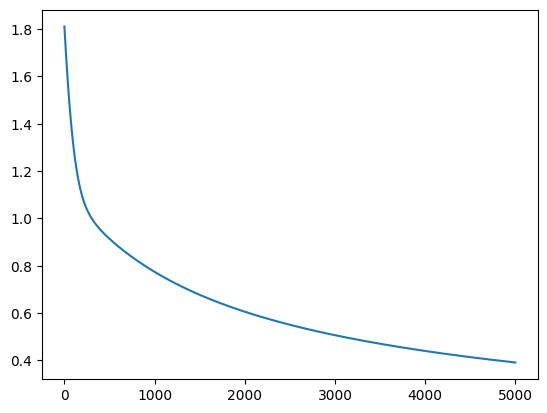

In [27]:
plt.plot(losses)

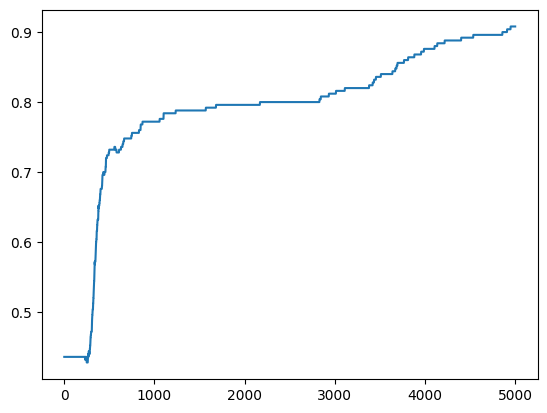

In [29]:
plt.plot(accuracies)

#### Exercises

1. We have not used the test portion of the dataset, modify the training loop to include tracking of test loss and test accuracy.
2. Add more metrics to be tracked, e.g., multi-class F1-score. The torchmetrics package has a lot of options in this sense: https://torchmetrics.readthedocs.io/en/stable/.

In [33]:
# Let's import needed libraries
import torchmetrics
from torch import optim

In [17]:
# Initialize the weight and bias matrix/vector
W, b = init()

losses = []
lossesTest = []
accuracies = []
accuraciesTest = []
f1_score_Test = []
precisionTest = []

f1 = torchmetrics.F1Score(num_classes=3) # F1 Score
precision = torchmetrics.Precision(average='samples', num_classes=3) # Precision

for i in range(5000):

  # Compute predictions through Softmax
  ypred = logreg(Xtrain, W, b)

  # Predictions for Test set through Softmax
  ypredTest = logreg(Xtest, W, b)

  # Compute the loss for Train and Test set
  loss = cross_entropy(ytrain, ypred)
  lossTest = cross_entropy(ytest, ypredTest)

  # We also use multiple metrics here through torchmetrics
  f1_score = f1(ypredTest, ytest)
  prec = precision(ypredTest, ytest)

  # Compute the gradients for both Train and Test set
  loss.backward()
  lossTest.backward()

  # We use the no_grad() function, because we do not need to keep track of
  # the next operations when computing the gradient.
  with torch.no_grad():
    
    # Apply gradients. We move the opposite direction 
    # in respect to the Gradient (Gradient Descent)

    # We need to move W & b in respect to minus(-) its gradient, 
    # moltiplied by a small step.
    W -= 0.01 * W.grad
    b -= 0.01 * b.grad

    # Gradients are accumulated (sum) when we call backward(), not overrided.
    # We need to zero them out before the next iteration.
    W.grad.zero_()
    b.grad.zero_()

    # We use the item() function in order to extract the scalar value.
    # Detach = We detach the "loss" tensor from the current graph.
    losses.append(loss.detach().item())
    accuracies.append(accuracy(ytrain, ypred).item())

    lossesTest.append(lossTest.detach().item())
    accuraciesTest.append(accuracy(ytest, ypredTest).item())
    f1_score_Test.append(f1_score.item())
    precisionTest.append(prec.item())

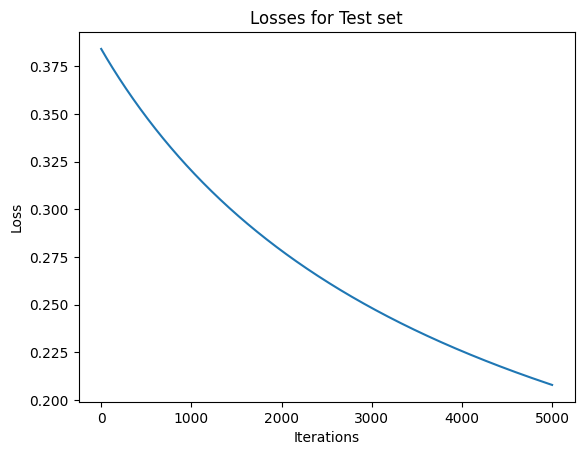

In [31]:
plt.plot(lossesTest)
plt.title("Losses for Test set")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

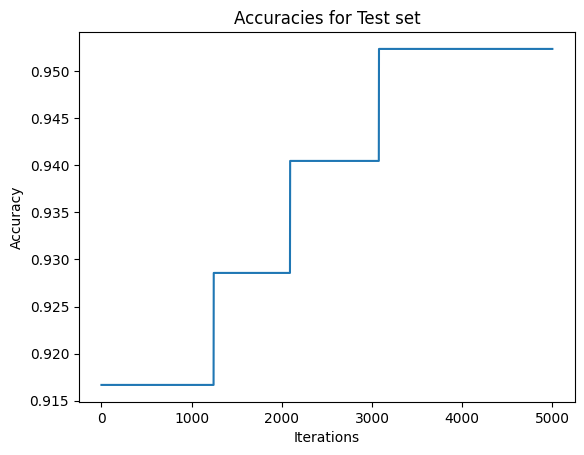

In [32]:
plt.plot(accuraciesTest)
plt.title("Accuracies for Test set")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

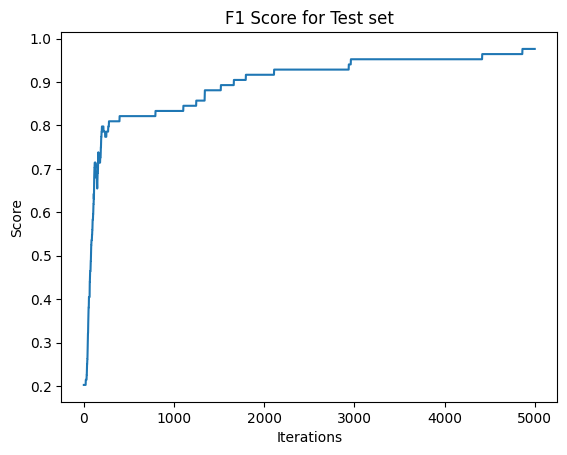

In [16]:
plt.plot(f1_score_Test)
plt.title("F1 Score for Test set")
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.show()

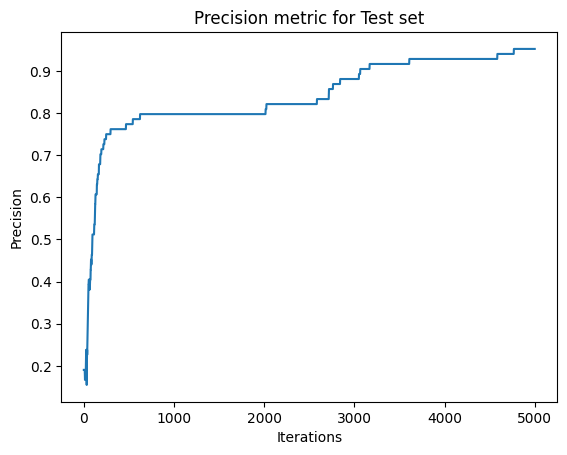

In [18]:
plt.plot(precisionTest)
plt.title("Precision metric for Test set")
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.show()

In [30]:
print(F"Max accuracy: {str(max(accuraciesTest)).rjust(25)}")
print(F"Max F1 score: {str(max(f1_score_Test)).rjust(25)}")
print(F"Max Precision score: {str(max(precisionTest))}")

Max accuracy:        0.9523809552192688
Max F1 score:        0.9523809552192688
Max Precision score: 0.9523810148239136


3. Momentum is a simple technique to improve the convergence speed of gradient descent. The key idea is to update each variable using a weighted average of the current gradient, and the gradient at the previous iteration (see Section 12.6 in the book). The weighting parameter is called the momentum weight. Implement momentum in the codelab, using a weight of 0.5.

In [58]:
# Initialize the weight and bias matrix/vector
W, b = init()

losses = []
lossesTest = []
accuracies = []
accuraciesTest = []

momentum = 0.5

optimizer = optim.SGD(params=[W,b], lr=0.0005, momentum=momentum)

for i in range(5000):

  # We zero the gradients of the optimizer at each iteration
  optimizer.zero_grad()

  # Compute predictions through Softmax
  ypred = logreg(Xtrain, W, b)

  # Predictions for Test set through Softmax
  ypredTest = logreg(Xtest, W, b)

  # Compute the loss for Train and Test set
  loss = cross_entropy(ytrain, ypred)
  lossTest = cross_entropy(ytest, ypredTest)

  # Compute the gradients for both Train and Test set
  loss.backward()
  lossTest.backward()
  optimizer.step()

  # We use the no_grad() function, because we do not need to keep track of
  # the next operations when computing the gradient.
  with torch.no_grad():
    
    # Apply gradients. We move the opposite direction 
    # in respect to the Gradient (Gradient Descent)

    # We need to move W & b in respect to minus(-) its gradient, 
    # moltiplied by a small step.
    W -= 0.01 * W.grad
    b -= 0.01 * b.grad

    # Gradients are accumulated (sum) when we call backward(), not overrided.
    # We need to zero them out before the next iteration.
    W.grad.zero_()
    b.grad.zero_()

    # We use the item() function in order to extract the scalar value.
    # Detach = We detach the "loss" tensor from the current graph.
    losses.append(loss.detach().item())
    accuracies.append(accuracy(ytrain, ypred).item())

    lossesTest.append(lossTest.detach().item())
    accuraciesTest.append(accuracy(ytest, ypredTest).item())

print(F"Accuracy test set with momentum {momentum}: {max(accuraciesTest)}")

Accuracy test set with momentum 0.5: 0.9404761791229248


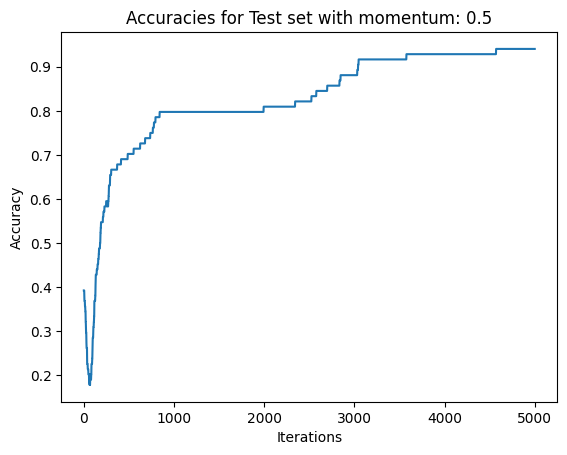

In [59]:
plt.plot(accuraciesTest)
plt.title(F"Accuracies for Test set with momentum: {momentum}")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()